# **5. Aprendizado de Máquina**
---

Neste capítulo você irá aprender:

1. O que é o Aprendizado de Máquina Supervisionado
2. Como aplicar modelos Aprendizado de Máquina para estimar Funções e Séries Temporais com os estimadores do `Scikit-Learn`
2. E como podem ser empregados modelos de Deep Learning para previsão de Séries Temporais a partir de um exemplo com `PyTorch`




Modelos de Aprendizado de Máquina, ou ML (*Machine Learning*), são aplicados a uma série de tarefas como identificação de fraudes em cartões de crédito e a recomendação de produtos no *e-commerce*, até sistemas para precificação e a previsão do tempo.

Esses modelos também vêm sendo aplicados com sucesso na previsão de Séries Temporais bastante complexas. Eles não têm a necessidade de assumir modelos aditivos ou multiplicativos, e nem eliminar tendências ou sazonalidades para serem aplicados. São bastante fáceis de usar estimando um grande conjunto de Séries com pouca ou quase nenhuma informação sobre sua estrutura (tendência, sazonalidade, periodicidade etc.), embora, essa falta de poder explicativo dos modelos de ML seja em muitos casos uma desvantagem desses modelos.

Apesar deste texto ser uma introdução ao tema de Séries Temporais, o uso recentes desses modelos vem crescendo em vários seguimentos, da predição de demanda de produtos à aplicações em ciência, telecomunicações e medicina, com soluções suportadas por grandes empresas de tecnologia como Meta (`Prophet`,`Neuralprophet`, `PyTorch`) e Google (`TensorFlow`). Assim, incluímos este capítulo para você conhecer esses modelos e algumas de suas aplicações, mesmo sendo um conteúdo que você não irá encontrar nos textos mais tradicionais da área.








In [1]:
#@markdown `imports`
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib.ticker as ticker

from datetime import datetime as dt

path_data = 'https://github.com/Introducao-Series-Temporais-em-Python/Book/raw/main/Data/'
plt.style.use([ 'grayscale' , 'https://github.com/Introducao-Series-Temporais-em-Python/Book/raw/main/tsp.mplstyle' ])

# Para ver os parâmetros empregados aqui
# plt.rcParams
# plt.rcParams['figure.figsize']

# O Aprendizado de Máquina Supervisionado para Aproximação de Funções

O Aprendizado de Máquina tem uma série de variantes para a solução de diferentes problemas que vão da classificação de clientes ao crédito e imagens, detecção de anomalias de tráfego, agrupamento de notícias até a transcrição e tradução automática de textos. Nesta introdução, entretanto, é suficiente nos determos nos modelos de ML empregados para aproximar funções. Esses modelos são modelos de **Aprendizado Supervisionado**, em que o aprendizado se dá a partir de um conjunto de dados de exemplos (conjunto de treinamento) de entradas e saídas. Quando os valores de saída são valores numéricos contínuos temos o caso particular dos de **Regressão**. Esses modelos buscam encontrar, a partir de um conjunto de dados de entrada e valores de saída, uma função que melhor ajusta esse conjunto de dados, isto é, uma função que melhor aproxima o mapeamento das entradas aos valores de saída.

> **Um modelo de Aprendizado de Máquina (Supervisionado) de Regressão busca encontrar, à partir de um conjunto de dados de entradas e seus valores de saída, uma função que melhor ajusta o mapeamento das entradas aos seus valores de saída.**

Você vai ver como empregar o Aprendizado de Máquina primeiramente para aproximar Funções para, na sequência, entender como empregar esses modelos para Previsão de Séries Temporais.

## Aproximando uma Função Linear

E. Dolbear, em “The cricket as a thermometer”, American Naturalist (1897) 31, 970-971 mostrou que a frequencia do canto (gorgeio) de grilos por minuto poderia ser empregada para *estimar* a temperatura ambiente:

$$T_{C}=f(N_{60})$$

G.W. Pierce, em “The Songs of Insects” (1948), apresenta 15 dessas medidas e convertemos abaixo as temperaturas de Fahreinheit para Celsius:

In [2]:
df = pd.read_csv(path_data + 'PierceCricketData.csv')
df['Temperature'] = np.round(( df['Temperature'] - 32 ) * 5/9,2)
df

,Chirps/Minute,Temperature
0,20.0,31.44
1,16.0,22.00
2,19.8,34.06
3,18.4,29.06
4,17.1,27.00
5,15.5,24.00
6,14.7,20.94
7,17.1,27.78
8,15.4,20.78
9,16.2,28.50


Aqui, temos um mapeamento de dados de entradas e saídas:

$$ f:N_{60} ⟶ T_{C} $$

e, embora você não conheça a função $T_{C}=f(N_{60})$, você observar em um gráfico que podemos buscar aproximar esses pontos por uma função linear, isto é:

$$T_{C} \approx a_0 + a_1 N_{60}$$



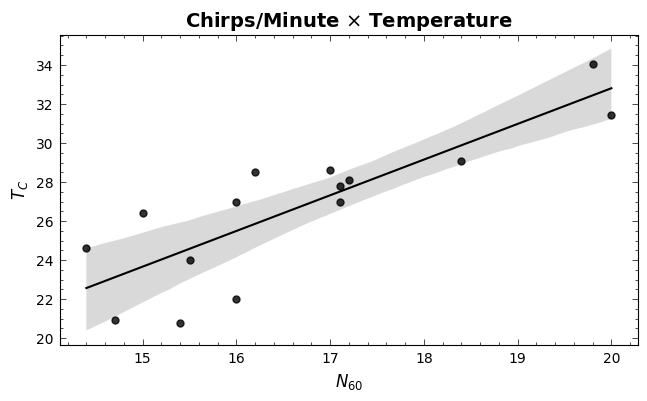

In [3]:
fig, ax = plt.subplots()

sns.regplot(x=df['Chirps/Minute'], y=df['Temperature'],ax=ax)

ax.set_title('Chirps/Minute $\\times$ Temperature',fontsize=14,weight='bold')
ax.set_xlabel('$N_{60}$',fontsize=12)
ax.set_ylabel('$T_{C}$',fontsize=12)

plt.show()

Essa função pode ser obtida a partir de uma regressão linear, que é um dos modelos mais simples de Aprendizado de Máquina. Os valores obtidos desse modelo são:

$$ T_C = -3.77 + 1.83 N_{60} $$

Sendo esses os coeficientes que melhor aproximam os dados de entrada e saída, isto é, têm a menor soma de erro entre os valores reais e os estimados por essa função.


## Esquema Geral do Aprendizado Supervisionado

Todos os modelos de Aprendizado Supervisionado, isto é, modelos que empregam um conjunto de exemplos (*conjunto de treinamento*) de entradas e suas saídas, como o conjunto de dados de gorgeios/min e temperaturas acima, seguem um mesmo esquema de geral de uso:

1. Existe uma função $f: X \longrightarrow y$ que não conhecemos mas queremos estimar.
> No nosso exemplo, é a função que leva a frequencia dos gorgeios às temperaturas.

2. Embora não conheçamos a função temos uma amostra de dados, um conjunto de *treinamento*, com as entradas e saídas $(X,y)$ e que empregaremos para *treinar* (aprender) o modelo a partir dos dados.
> No nosso exemplo é o conjunto de 15 pontos coletados por G.W. Pierce, em “The Songs of Insects”.   

3. Vários tipos de função podem ser empregadas para aproximar o mapeamento do conjunto de dados como, funções polinomiais, exponenciais, trigonométricas etc. esses tipos consistem em diferentes *classes* de funções.
> No nosso exemplo, após inspecionar os dados, pareceu suficiente empregarmos um modelo linear e portanto, a classe de funções do tipo $g(x) = a_0 + a_1 x$.   

4. O Aprendizado (de Máquina) consiste, então, em estimar os melhores parâmetros da classe de modelos escolhida que minimiza o erro, ou a diferença entre os dados e os valores estimados $|| f(x)  - g(x) ||$.  
> No nosso exemplo, o aprendizado consiste em encontrar os coeficientes $a_0, a_1$, da classe de funções lineares $g(x) = a_0 + a_1 x$,  tal que o erro é mínimo $|| f(x)  - g(x) ||$ é mínimo. Esses coefientes resultam $g(x) = -3.77 + 1.83 x$.

5. O modelo obtido pode ser, então, empregado para estimativa de novos valores uma vez que aproxima a função original desconhecida.

Estes passos são representados na figura 1.

<img src="https://github.com/Introducao-Series-Temporais-em-Python/Book/raw/main/Figures/ML_1.png" width=800>

<small><b>
Figura 1. Esquema Geral do Aprendizado de Máquina Supervisionado e os respectivos comandos empregados no uso de estimadores do `scikit-learn`.


## Esquema Geral do Aprendizado Supervisionado com o `scikit-learn`

O `scikit-learn` é um dos mais populares frameworks de aprendizado de máquina em `Python` e tem diferentes modelos de aprendizado supervisionado e não supervisionados. Todos os modelos empregam um esquema similar de aplicação baseado em *estimadores*. A figura 1 apresenta para cada etapa do Aprendizado Supervisionado os respectivos comandos no uso de estimadores do `scikit-learn`.

Veja como empregamos `scikit-learn` para estimar o modelo linear do nosso exemplo dos gorgeios e temperaturas e chegar aos coeficientes que resultam em $ g(x) = -3.77 + 1.83 x $.  

In [4]:
from sklearn import linear_model

X=df[['Chirps/Minute']]
y=df['Temperature']

reg = linear_model.LinearRegression()

reg.fit(X, y)


LinearRegression()

```
      X=df[['Chirps/Minute']]
      y=df['Temperature']
```
1. Define o nosso conjunto de treinamento, com as entradas e saídas. No nosso exemplo há um único conjunto de valores de entrada representado pelos valores de frequência dos gorgeios. O `X` (maísculo), empregado, denota que podemos ter entradas de mais que uma dimensão, caso em que $X = (x_1, ..., x_n)$.

```
      reg = linear_model.LinearRegression()
```

2. Define a classe de modelo a ser empregada. No caso definimos um modelo de regressão linear, mas outros tipos de função podem ser empregados como você verá mais adiante.

```
      reg.fit(X, y)
```

3. A o método `fit(X,y)` aplicado ao estimador instanciado `reg` realiza o aprendizado, que consiste em obter os melhores parâmetros do modelo definido. No caso do modelo linear, e sendo uma função de uma única variável, esses parâmetros são os coeficientes independente $a_0$ e $a_1$.

Você pode acessar esses coeficientes como a seguir.

In [5]:
reg.coef_

array([1.82894339])

In [6]:
reg.intercept_

-3.7693372345321947

Você pode agora empregar diretamente esses valores para estimar novos valores, por exemplo a temperatura para 16 ou 22 gorgeios/min.

In [7]:
X_test = pd.DataFrame({'Chirps/Minute':[12, 22]})
y_pred = reg.intercept_ + reg.coef_ * X_test.values
y_pred

array([[18.17798343],
       [36.46741732]])

Mas é preferível você empregar o método `predict()` aplicando-o ao estimador para fazer este cálculo. Para a função linear o uso direto dos coeficientes é simples, mas para outras classes de funções as formas de cálculo e os parâmetros podem ser bem complexos de aplicar.

```
      reg.predict(X_test)
```



In [8]:
X_test = pd.DataFrame({'Chirps/Minute':[12, 22]})
y_pred = reg.predict(X_test)
y_pred

array([18.17798343, 36.46741732])

A seguir, o resultado do modelo aplicado a 100 diferentes valores de entrada.

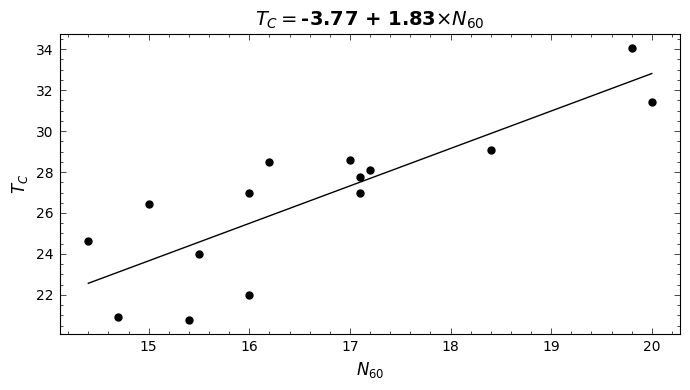

In [9]:
X_test = pd.DataFrame({'Chirps/Minute':np.linspace(df['Chirps/Minute'].min(),df['Chirps/Minute'].max(),100)})
y_pred = reg.predict(X_test)

fig, ax = plt.subplots()

ax.scatter(x=df['Chirps/Minute'], y=df['Temperature'])
ax.plot(X_test, y_pred)

ax.set_title('$T_{C}=$' + str(np.round(reg.intercept_,2)) + ' + ' + str(np.round(reg.coef_[0],2)) + '$\\times N_{60}$' ,fontsize=14,weight='bold')
ax.set_xlabel('$N_{60}$',fontsize=12)
ax.set_ylabel('$T_{C}$',fontsize=12)

plt.tight_layout()
plt.show()

## Outros Modelos não lineares

O modelo linear é importante, mas há uma série de problemas onde a classe de funções lineares é insuficiente para aproximar o conjunto de dados.

O *Potencial de Ação* é uma *função* que explica a ativação dos neurônios e que tem um papel importante nas neurociências e aplicações médicas. O conjunto de dados a seguir mostra o valor médio do potencial de ação de um neurônio em um experimento ao longo do tempo.

In [10]:
import seaborn as sns
df = sns.load_dataset('dots')
df = df[(df.choice == 'T2') & (df['align'] == 'dots')]
df = df[['time','firing_rate']].groupby('time')['firing_rate'].mean().reset_index()
df.head()

,time,firing_rate
0,-80,34.350067
1,-60,34.373160
2,-40,34.740826
3,-20,35.492313
4,0,35.694765


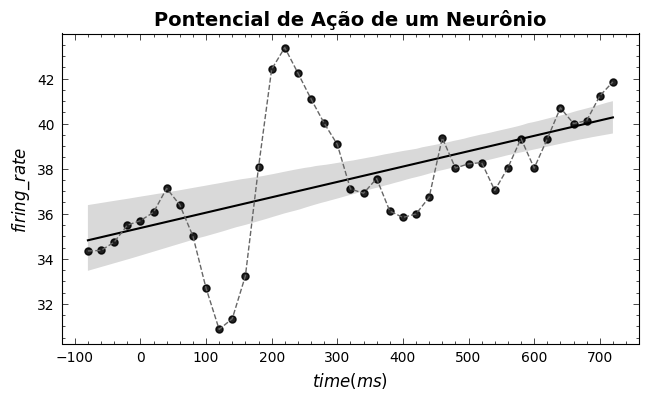

In [11]:
sns.regplot(x=df.time, y=df.firing_rate)
sns.lineplot(x=df.time, y=df.firing_rate, linestyle='--')
plt.scatter(x=df.time, y=df.firing_rate,alpha=0.3)

plt.title('Pontencial de Ação de um Neurônio')
plt.xlabel('$time (ms)$')
plt.ylabel('$firing\_rate$')
plt.show()

Certamente, você observa que o modelo linear não é um bom modelo para esses dados. Felizmente existem muitos outros tipos de regressores (não lineares) que podem ser empregados.

<img src="https://github.com/Introducao-Series-Temporais-em-Python/Book/raw/main/Slide3.PNG" width=800>

<small>
<b>
Figura 2. Esquema geral do Aprendizado Supervisionado de Máquina e outras Classes de Regressores.

Esses modelos empregam outros princípios, às vezes, bastante diferentes. Você pode pensar, por exemplo, nos modelos regressão polinomial ou de aproximação de funções por séries, como as séries de Taylor e Fourier. Mas ainda existem modelos que empregam paradigmas ainda mais diferentes, como modelos baseados em Árvores de Decisão, K-Vizinhos mais Próximos ou os modelos de Redes Neurais Artificiais.

Não vamos entrar em detalhes de como cada um desses modelos funciona, mas o importante é que você entenda que, à exemplo do modelo de Regressão Linear, o Aprendizado de Máquina consiste em buscar, em uma classe de modelos escolhida, os parâmetros dessa classe de modelos que melhor se ajustam aos dados.

> **Basicamente, o Aprendizado de Máquina consiste em buscar, em uma classe de modelos escolhida, os parâmetros dessa classe de modelos que melhor se ajustam aos dados.**



## Outros Modelos com o `scikit-learn`

Antes de aplicarmos outros modelos ao conjunto de dados de Potencial de Ação de um neurônio, vamos entender uma prática importante do Aprendizado de Máquina que é a separação dos conjuntos de dados de treinamento e teste.



### Conjunto de Treinamento e Teste

Empregar o mesmo conjunto de dados para treinar o modelo e medir o erro do modelo (ou o seu grau de acerto), é mais ou menos como você dar uma prova para medir o resultado do aprendizado dos alunos que tenha somente testes que eles já viram durante o aprendizado, ou reino. Se o aluno memorizou as respostas, ele pode ter um resultado muito bom nos testes sem, de fato, ter aprendido. É importante, portanto, para medir o resultado do aluno com testes novos, que não tenham sido apresentados antes ao aluno. O mesmo se aplica ao Aprendizado de Máquina, devemos separar do nosso conjunto de dados uma parcela para o aprendizado e uma outra parcela para avaliar resultado do modelo, de forma que esta última parcela de teste não contamine o treinamento.

```
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
```

A função `train_test_split()` permite fazer essa separação de modo simples, separando porções dos dados de forma aleatória. Acima, o comando separa 20% dos dados para teste e o `random_state=1` estabelece uma semente de geração aleatória para reprodutibilidade dos resultados (isto é, sem esse parâmetro novos e diferentes valores aleatórios são produzidos a cada execução).

Em Séries Temporais, para a previsão de valores, podemos ainda empregar a porção mais recente dos dados (20% por exemplo) utilizando os valores mais antigos da Série (80%), para o treinamento.

Aplicando essa separação de dados de treinamento e teste o modelo linear para estimativa da função de Potencial Ação ficará do seguinte modo:

In [12]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split

X = df[['time']]
y = df.firing_rate

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

reg = linear_model.LinearRegression()

reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)

reg.score(X_test,y_test)

0.2714028728260297

Você deve notar o uso do conjunto de treinamento na função `fit()` (o treinamento do modelo) e do conjunto de teste na função `predict()`, que empregamos para validar o resultado, comparando os valores previstos (`y_pred`) com os valores reais (`y_test`). O `score()` do modelo linear é o coeficiente de determinação ($R2$), e o valor $0.27$ diz que o modelo linear explica muito pouco a variação dos dados (o valor $1$ seria o valor máximo para um conjunto de dados perfeitamente linear, e zero o menor valor), o que você já tinha observado.

Você pode observar o erro dos valores previstos pelo modelo linear no conjunto teste no gráfico abaixo. Os valores previstos (`y_pred`) encontram-se representados por marcadores *quadrados* e os valores reais (`y_test`) por *diamonds*.

In [13]:
def plot_firing(title='Pontencial de Ação de um Neurônio'):
  fig, ax = plt.subplots()
  sns.lineplot(x=X_train.time, y=y_train,alpha=0.35,ax=ax)
  ax.scatter(X_train.time, y_train,alpha=0.35,label='Train',marker='o')
  ax.scatter(X_test.time, y_test,label='Test',marker='D',s=36,color='k')

  ax.scatter(X_test.time,y_pred,label='Predictions',marker='s',s=36,color='k')
  ax.plot(X,reg.predict(X),lw=1,linestyle='--',color='k')

  ax.set_title(title)
  ax.set_xlabel('$time (ms)$')
  ax.set_ylabel('$firing\_rate$')
  ax.legend()

  ax.text(500,32,'Model score = ' + str(np.round(reg.score(X_test,y_test),2)))

  plt.show()

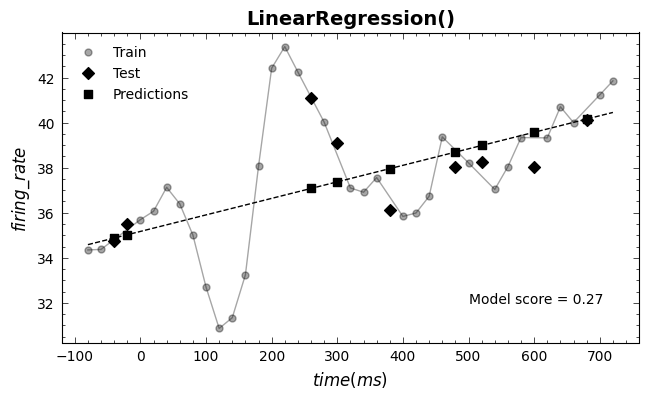

In [14]:
plot_firing('LinearRegression()')

Esse é o melhor modelo que a classe de regressores lineares pode fornecer e, de fato, você observa que ele se ajusta muito pouco aos dados. Modelos lineares não podem capturar a grande não linearidade da função de ativação.



### Um Modelo não linear: Regressor K-Vizinhos mais Próximos

O modelo **K-Vizinhos mais Próximos** é um modelo que ilustra bastante bem haverem outros princípios que permitem a aproximação de funções. A ideia do K-Vizinhos mais Próximos é que a estimativa de um valor desconhecido da função, ou do conjunto de teste, pode ser obtido por uma média do valor dos vizinhos mais próximos no conjunto de treinamento. O número de vizinhos $k$ variando de 1 a $n$ elementos do conjunto mais, em geral, não sendo muito superior a uma ou duas dezenas.  

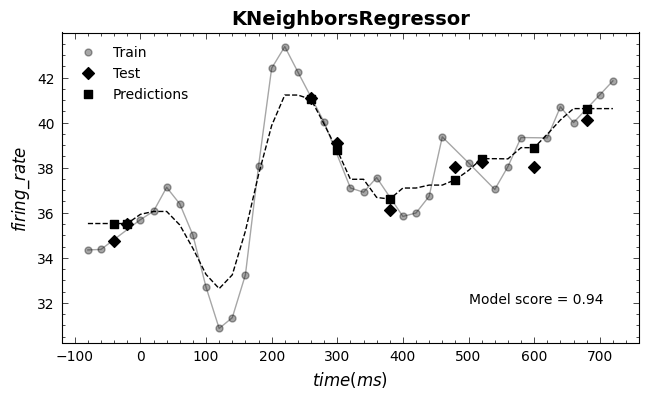

In [15]:
from sklearn.neighbors import KNeighborsRegressor
reg = KNeighborsRegressor()

reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
plot_firing(title='KNeighborsRegressor')


É uma ideia bastante simples e basta você encontra os $k$ vizinhos mais próximos de um ponto que você deseja estimar a função e fazer a média desses valores. Apesar da simplicidade o modelo consegue capturar bastante bem a não linearidade da função como você pode ver acima. Esse modelo, entretanto, não é adequado para *forecasting*, isto é, as estimativas de valores *futuros* e fora do intervalo de valores do conjunto de treinamento e veremos mais adiante como ajustar esses modelos para a predição de séries temporais.

### Outros Modelos Regressores

Existem muitos outros modelos e que empregam paradigmas bastante diferentes do modelo Linear ou do modelo de k-Vizinhos mais próximos e você poderá encontrar muitas referências sobre isso.

O que nos interessa é saber que existem muitos modelos e que, por partirem de princípios de construção diferentes, levam a diferentes soluções de aproximação da função original.

A seguir você pode ver a aplicação de 3 outros modelos regressores bastante empregados **Máquinas de Vetores de Suporte**, **Decision Tree Regressor** e o modelo **XGBoosting Regressor**. Todos têm a mesma lógica de aplicação dos modelos anteriores, linear e k-vizinhos mais próximos, e você pode alterar o código abaixo para experimentar ainda outros modelos.

In [16]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost.sklearn import XGBRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import SGDRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor # entradas precisam ser normalizadas

X = df[['time']]
y = df.firing_rate

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

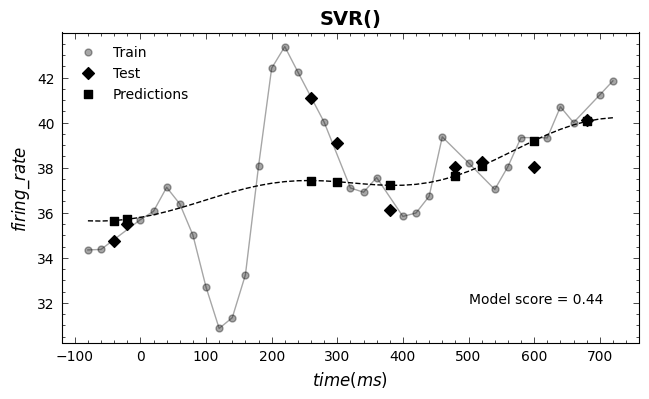

In [17]:
reg = SVR()

reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
plot_firing(title='SVR()')

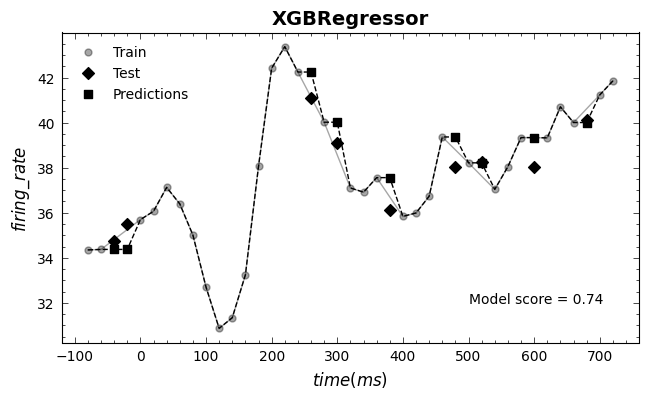

In [18]:
reg = XGBRegressor()

reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
plot_firing(title='XGBRegressor')

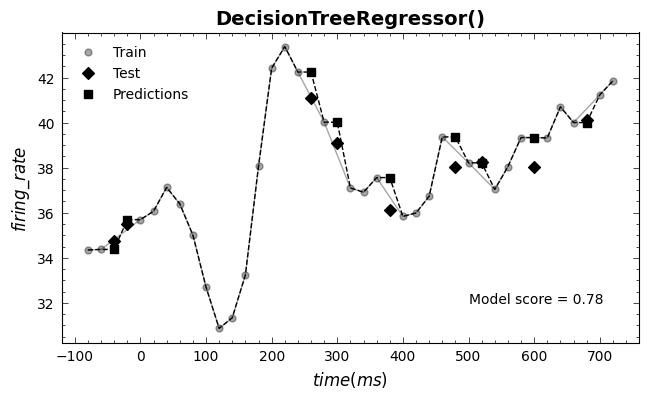

In [19]:
reg = DecisionTreeRegressor()

reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
plot_firing(title='DecisionTreeRegressor()')



# Empregando Regressores para Séries Temporais

Você já viu que Séries Temporais são funções com características bastante próprias. Na maior parte dos casos o valor da Série não depende exatamente do tempo, mas dos valores anteriores (lembre dos modelos auto-regressivos) e a aproximação de funções como você viu até aqui não conseguiriam capturar boa parte do comportamento das Séries, como sazonalidades. Como então empregar esses regressores para Séries Temporais.


Como você acompanhou até aqui os modelos de Aprendizado Supervisionado procuram *mapear* um conjunto de dados de entrada e suas saídas. A entrada `X`, entretanto, pode ter várias dimensões e você pode pensar em uma função de várias variáveis $f(x_1, x_2, ..., x_n)$. A ideia é empregar os valores regressivos da Série como essas variáveis criando o seguinte conjunto de dados:

$$  f: x_{t-n}, x_{t-n-1}, ..., x_{t-1} \rightarrow x_t $$

onde $n$ é o número de termos regressivos que queremos empregar.



## Série de Emissões de CO2

Veja em um exemplo como podemos construir esses dados de treinamento.

In [22]:
df = pd.read_csv(path_data + 'co2.csv')
df.head()

,Date,time,CO2
0,1981-05-01,0,342.74
1,1981-06-01,1,342.08
2,1981-07-01,2,340.32
3,1981-08-01,3,338.26
4,1981-09-01,4,336.52


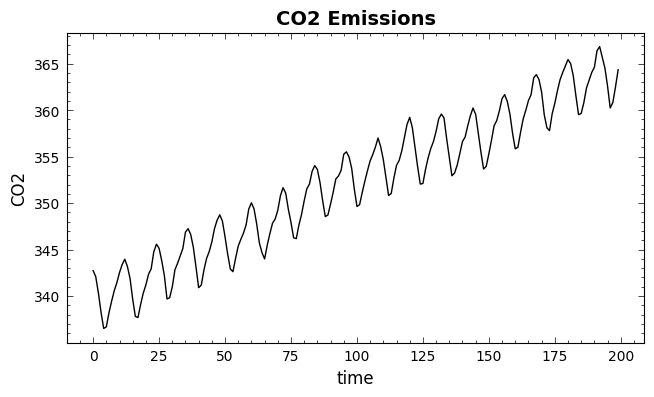

In [23]:
plt.plot(df.time, df.CO2)
plt.title('CO2 Emissions')
plt.xlabel('time')
plt.ylabel('CO2')
plt.show()

Os dados de `CO2` são os valores da nossa Série Temporal. Se você quiser empregar dois termos regressores da série, isto é, obter $x_t$ a partir de 2 termos anteriores, $x_t = f(x_{t-1}, x_{t-2})$, precisamos construir o conjunto de dados representado na figura 3.

<img src="https://github.com/Introducao-Series-Temporais-em-Python/Book/raw/main/Figures/ML_TS.png" width=1000>



<small><b>
Figura 3. Mapeamento dos termos regressores da Série Temporal para entradas de dados X e y no Aprendizado de Máquina.

Para isso podemos empregar a função `shift()`(veja no nosso Guia Rápido).

In [24]:
df['CO2_t-1'] = df.CO2.shift()
df['CO2_t-2'] = df.CO2.shift().shift()
df.head()

,Date,time,CO2,CO2_t-1,CO2_t-2
0,1981-05-01,0,342.74,NaN,NaN
1,1981-06-01,1,342.08,342.74,NaN
2,1981-07-01,2,340.32,342.08,342.74
3,1981-08-01,3,338.26,340.32,342.08
4,1981-09-01,4,336.52,338.26,340.32


In [25]:
df.dropna(inplace=True)
df = df[['Date', 'time', 'CO2_t-2', 'CO2_t-1', 'CO2']]
df[['CO2_t-2', 'CO2_t-1', 'CO2']].head()

,CO2_t-2,CO2_t-1,CO2
2,342.74,342.08,340.32
3,342.08,340.32,338.26
4,340.32,338.26,336.52
5,338.26,336.52,336.68
6,336.52,336.68,338.19


Temos agora um conjunto de dados $f:X \longrightarrow y$ e podemos, portanto, aplicar um modelo regressor de Aprendizado de Máquina.

In [26]:
from sklearn import linear_model

X = df.drop(columns=['CO2','Date'])
y = df.CO2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

reg = linear_model.LinearRegression()

reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)



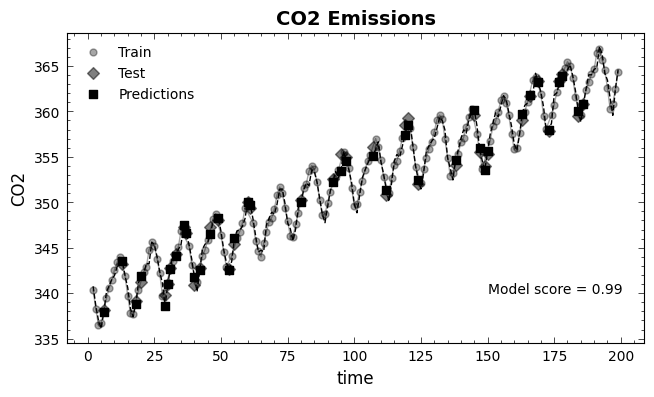

In [27]:
fig, ax = plt.subplots()
sns.lineplot(x=X_train.time, y=y_train,alpha=0.35,ax=ax)
ax.scatter(X_train.time, y_train,alpha=0.35,label='Train',marker='o')
ax.scatter(X_test.time, y_test,label='Test',marker='D',s=36,color='k',alpha=0.5)

ax.scatter(X_test.time,y_pred,label='Predictions',marker='s',s=36,color='k')
ax.plot(X.time,reg.predict(X),lw=1,linestyle='--',color='k')

ax.set_title('CO2 Emissions')
ax.set_xlabel('time')
ax.set_ylabel('CO2')
ax.legend()

ax.text(150,340,'Model score = ' + str(np.round(reg.score(X_test,y_test),2)))

plt.show()


In [28]:
reg.coef_

array([ 0.03971179, -0.8548501 ,  1.54281965])

Veja que o resultado estimado (linha tracejada e pontos com marcadores *quadrados* do conjunto de teste) são bastante próximos dos dados reais, apesar do modelo linear empregado!

## Bike Sharing: Machine Learning


Nos capítulos anteriores você pôde acompanhar análises completas da Série de Dados Bike Sharing. Esta é uma Série bastante complexa embora com características bastante comuns a um grande número de problemas que envolvem demanda de produtos e serviços. Você agora aplicar um modelo de Aprendizado de Máquina a essa Série.

In [124]:
bikes = pd.read_csv(path_data + 'dados_bike.csv')
df = bikes.copy()
df.head()


,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,year
0,2015-01-04,1039,4.0,3.5,100.0,15.0,4.0,0.0,1.0,3.0,2015
1,2015-01-05,3161,10.0,9.0,93.0,14.0,4.0,0.0,0.0,3.0,2015
2,2015-01-06,3534,11.0,11.0,88.0,27.5,7.0,0.0,0.0,3.0,2015
3,2015-01-07,3618,10.0,7.0,87.0,30.5,7.0,0.0,0.0,3.0,2015
4,2015-01-08,2351,12.0,12.0,88.0,27.0,7.0,0.0,0.0,3.0,2015


A série de dados que temos interesse é agora a dos valores `cnt`, valores máximos de demanda de bicicletas por dia e representada pela linha amarela no gráfico abaixo.

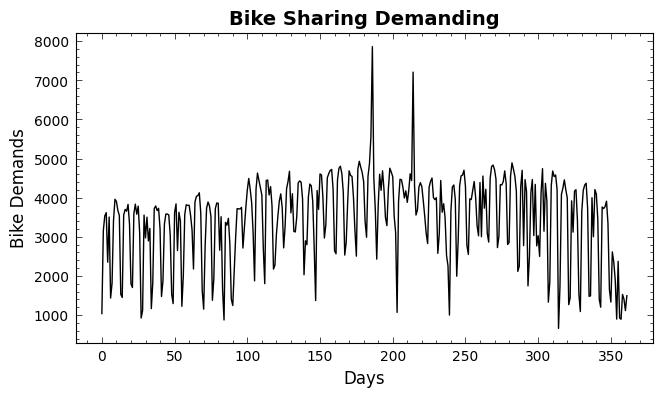

In [125]:
sns.lineplot(x = df.cnt.index, y = df.cnt)

plt.title('Bike Sharing Demanding', fontsize=14, weight='bold')
plt.xlabel('Days')
plt.ylabel('Bike Demands')
plt.show()

### Modelo ARIMA

Vamos recordar que chegamos ao seguinte modelo ARIMA e forecasting para os 20% dados finais da Série (Conjunto de Teste) nos capítulos anteriores:

In [126]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import acf, pacf

In [127]:
df = df[['cnt']]
df.columns = ['value']
df = df.reset_index(drop=True)


In [128]:
test_size = int(0.2*len(df))
train_size = len(df) - test_size

# Create Training and Test
train = df.value[:train_size]
test = df.value[train_size:]

In [129]:
p = 7
d = 2
q = 1

model = ARIMA(train, order=(p,d,q))
model_fit = model.fit()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [130]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  290
Model:                 ARIMA(7, 2, 1)   Log Likelihood               -2286.978
Date:                Thu, 18 Jan 2024   AIC                           4591.955
Time:                        19:11:08   BIC                           4624.922
Sample:                             0   HQIC                          4605.166
                                - 290                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5925      0.064     -9.244      0.000      -0.718      -0.467
ar.L2         -0.6578      0.091     -7.204      0.000      -0.837      -0.479
ar.L3         -0.6135      0.090     -6.822      0.0

In [131]:
history = [x for x in train]
predictions = list()

# forward validation
for t in test.index:
  # print(t)
	model = ARIMA(history, order=(7,2,1))
	model_fit = model.fit( )
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)



/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: Conver

In [132]:
#@markdown
def plot_forecast(y, y_pred, X_train, title='Forecasting'):

  plt.plot(y, alpha=0.3, label='Real', color='k')
  plt.plot(y_pred, alpha=0.7, label='Forecast', color='k', linestyle='--')

  plt.plot(y_pred[0:X_train.shape[0]], alpha=0.9, label='Predicted', color='k', linestyle=':')

  plt.vlines(x=y.index[X_train.shape[0]] , ymin=0, ymax=y.max(), linestyle='--')

  plt.title(title)
  plt.xlabel('Days')
  plt.ylabel('Bike Demands')

  plt.text(100, 0 , '0.8, conjunto de treinamento')
  plt.text(300 , 0 , '0.2, de teste')
  plt.legend()
  plt.show()

  return

In [133]:
#@markdown
# metrics
from statsmodels.tsa.stattools import acf

def forecast_accuracy(forecast, actual, print_flag=True):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)                           # ME
    mae = np.mean(np.abs(forecast - actual))                  # MAE
    mpe = np.mean((forecast - actual)/actual)                 # MPE
    mse = np.mean((forecast - actual)**2)                     # MSE
    rmse = np.mean((forecast - actual)**2)**.5                # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]                 # CORR
    acf1 = acf(forecast - actual)[1]                          # ACF1

    metrics = {'MSE':mse, 'MAPE':mape, 'ME':me, 'MAE': mae, 'MPE': mpe, 'RMSE':rmse, 'ACF1':acf1, 'CORR':corr}

    if print_flag:
      for key, value in metrics.items():
        print(f'{key}: \t {value:.2f}')

    return metrics



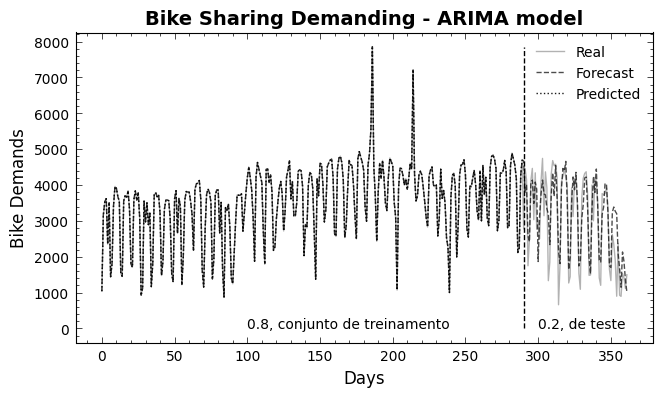

MSE: 	 493859.39
MAPE: 	 0.28
ME: 	 159.20
MAE: 	 539.22
MPE: 	 0.18
RMSE: 	 702.75
ACF1: 	 -0.12
CORR: 	 0.84


In [134]:
y_pred = np.concatenate( (np.array( history[0:train_size] ).reshape(-1), np.array(predictions).reshape(-1)) )

plot_forecast(pd.DataFrame( history ), y_pred, np.array( history[0:train_size] ), title='Bike Sharing Demanding - ARIMA model')
cur_metrics = forecast_accuracy(y_pred[train_size::], df[train_size::].values.reshape(-1))

dict_metrics = {}
dict_metrics['ARIMA Model'] = cur_metrics

### Modelo de Aprendizado de Máquina

Para o Aprendizado de Máquina vamos empregar duas funções, uma para criar o conjunto de entradas com os termos regressores da Séries (empregaremos 7 termos, no valendo da análise do modelo ARIMA anterior) e outra para separar o conjunto de Treinamento e Teste da Série. Empregaremos 20% dos dados mais recentes para o Teste de Previsão dos valores.

In [135]:
def ml_timeseries_df(df, n_lags, prefix=''):

	df_ml = pd.DataFrame()

	for i in range(n_lags,0,-1):
		df_ml[prefix + 't-' + str(i)] = df.shift(i).values[:,0]
	df_ml['t'] = df.values[:,0]
	df_ml = df_ml[n_lags:]
	df_ml = df_ml.reset_index(drop=True)

	return df_ml

df = ml_timeseries_df(bikes[['cnt']], n_lags=7)
df.head()

,t-7,t-6,t-5,t-4,t-3,t-2,t-1,t
0,1039.0,3161.0,3534.0,3618.0,2351.0,3505.0,1436.0,1813
1,3161.0,3534.0,3618.0,2351.0,3505.0,1436.0,1813.0,3418
2,3534.0,3618.0,2351.0,3505.0,1436.0,1813.0,3418.0,3960
3,3618.0,2351.0,3505.0,1436.0,1813.0,3418.0,3960.0,3904
4,2351.0,3505.0,1436.0,1813.0,3418.0,3960.0,3904.0,3673


Organizado os dados desse modo podemos separar a primeira porção dos dados, $0.8$, para o treinamento do modelo e aplicarmos ao restante, $0.2$, o *forecasting* observando os resultados.

In [136]:
def split_train_test(X, y, test_perc=0.2):

  test_size = int(len(df) * test_perc)
  train_size = len(df) - test_size

  X_train, y_train  = X[:train_size], y[:train_size]
  X_test, y_test = X[train_size:], y[train_size:]

  return X_train, y_train, X_test, y_test

X = df.drop(columns='t')
y = df[['t']]

X_train, y_train, X_test, y_test = split_train_test(X, y, test_perc=0.2)

O código para aplicação do Aprendizado de Máquina é o mesmo que empregamos antes e você pode empregar quaisquer dos regressores do `scikit_learn`.



#### Decision Tree Regressor

In [137]:
from sklearn.tree import DecisionTreeRegressor

reg = DecisionTreeRegressor(random_state=0)
reg.fit(X_train, y_train)

y_pred = reg.predict(X)

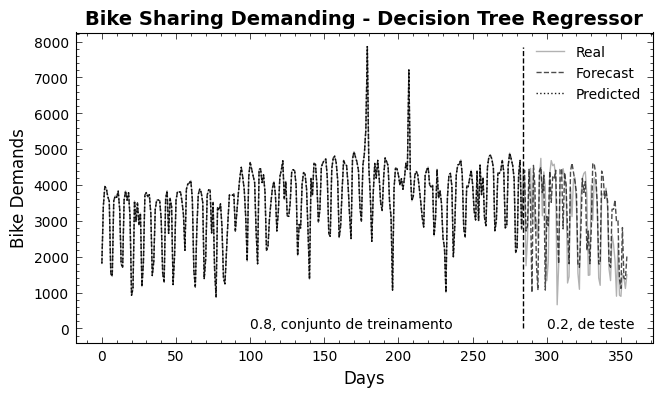

In [138]:
plot_forecast(y, y_pred, X_train, title='Bike Sharing Demanding - Decision Tree Regressor')

In [139]:
cur_metrics = forecast_accuracy(y_pred[len(y_train):], y[len(y_train):].values.reshape(-1))
dict_metrics['DecisionTreeRegressor'] = cur_metrics

MSE: 	 865131.56
MAPE: 	 0.34
ME: 	 180.15
MAE: 	 687.96
MPE: 	 0.20
RMSE: 	 930.12
ACF1: 	 0.07
CORR: 	 0.72


#### XGBoost Regressor



In [140]:
from xgboost.sklearn import XGBRegressor

reg =  XGBRegressor(random_state=0)
reg.fit(X_train,y_train.values.reshape(-1))

y_pred = reg.predict(X)

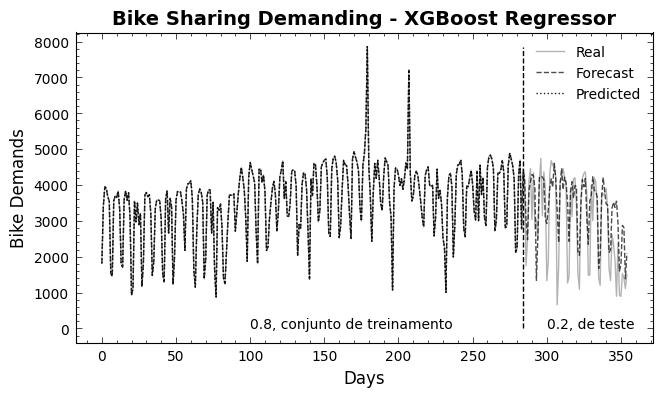

MSE: 	 823084.38
MAPE: 	 0.40
ME: 	 383.65
MAE: 	 665.43
MPE: 	 0.33
RMSE: 	 907.24
ACF1: 	 0.11
CORR: 	 0.77


In [141]:
plot_forecast(y, y_pred, X_train, title='Bike Sharing Demanding - XGBoost Regressor')

cur_metrics = forecast_accuracy(y_pred[len(y_train):], y[len(y_train):].values.reshape(-1))
dict_metrics['GradientBoostingRegressor'] = cur_metrics

As métricas de avaliação de um modelo de previsão podem ser muitas e, em geral, não temos nenhuma métrica que defina este ou aquele modelo como o melhor em quaisquer casos. Mas você pode observar que os modelos de Aprendizado de Máquina conseguem aproximar bastante bem a série de dados do nosso exemplo quando comparado ao modelo tradicional ARIMA (veja, por exemplo o erro absoluto médio MAE) requerendo um mínimo de esforço de análise e poderíamos ainda refinar esses modelos para chegar a métricas ainda melhores, pois empregamos aqui parâmetros padrão em todos eles. Há também formas de variar os parâmetros dos modelos de modo a encontrar de forma *automática* os melhores modelos, algo que conhecemos como *Auto ML* e semelhante ao que você viu nos capítulos anteriores com o *Auto ARIMA* do pacote `pmdarima`.

# Modelos Neurais

As Redes Neurais constituem uma classe bastante específica de modelos de Aprendizado de Máquina e Redes Profundas, Deep Learning, estão em geral por traz da maior parte das aplicações modernas que envolvem grandes volumes de dados e dados multidimensionais como os exemplos da Google, YouTube e Tesla que citamos acima.    

Apesar disso o modelo de um neurônio artificial é bastante simples.

## Neurônio Artificial: Perceptron

Um neurônio artificial implementa uma combinação linear de entradas a qual aplica uma **função de ativação** $\sigma$ para produzir uma saída.

$$ f(X) = \sigma( w_0 + w_1 x_1 + ... + w_n x_n ) $$

O treinamento do neurônio é feito ajustando-se os pesos $w_n$ para minimizar o erro de predição e estimar a saída $f(X) \cong y$.

$$ \min_{w_i} \sum || f(X)- y || $$

Semelhante aos coeficientes de uma regressão linear, aprendizado de um neurônio passa a ser um **problema de otimização** em buscar os valores $w_0, w_1, ..., w_n$ que melhor se ajustam aos dados.


### Funções de Ativação

Combinações de operadores lineares são também lineares. Desse modo, sem uma função de ativação, as redes neurais seriam equivalentes a um modelo  linear. As funções de ativação são uma escolha importante na arquitetura de uma rede neural e facilitam a modelagem de relações mais complexas. As funções de ativação mais comuns encontram-se abaixo.

$$ f(x) = \frac{1}{(1 + e^{-x})} \quad \textrm{, Logistic } $$

$$ f(x) = \frac{e^{x} - e^{-x}}{e^{x} + e^{-x}}\quad \textrm{, Tanh} $$

$$ f(x) = max(0,x) \quad \textrm{, ReLu} $$

$$ f(x) = log(1 + e^{x}) \quad \textrm{, Softplus} $$

E, não sem motivo, essa função leva o mesmo nome da função neuronal que vimos antes ;-).

## Redes Neurais

Um único neurônio artificial tem uma capacidade bastante limitada representar funções. Para aumentarmos essa capacidade e podemos ter um modelo de aproximação universal esses neurônios podem ser combinados em camadas de modo que as saídas dos neurônios de uma camada possam ser entrada para camadas seguintes de neurônios.

As camadas externas são as camadas de entrada e saída da rede. As camadas internas são as camadas de ocultas (hidden) da rede. As redes podem ter diferentes configurações com diferentes números de entradas, saídas e número de camadas.

Essas redes são conhecidas como redes multi-camada, MLP multi-layer perceptron ou feed-forward  e as entradas são processadas em sequência, uma camada após a outra.

O problema de aprendizado do modelo é, neste caso, bastante mais complexo e é obtido em um processo de iterações e aproximações sucessivas, à exemplo de um método de gradiente para o cálculo de zero de funções. O que importa é sabermos que poderão ser encontrados um conjunto de pesos $w_{j,i}$, onde $j$ é agora a dimensão camada da rede, e que aproximarão o conjunto de dados de treinamento.


<figure>
<br>
<img src="https://github.com/Introducao-Series-Temporais-em-Python/Book/raw/main/Figures/nn.png" width=400, align="center">
<br>
<br>







<small>
<b>
Figura 4. Esquema de uma Rede de Neurônios Multicamada, MLP.

## `Scikit-Learn` MLP

A biblioteca `Scikit-Learn` implementa um modelo neural multicamada MLP. A forma de aplicação é a mesma dos regressores anteriores.


In [142]:
from sklearn.neural_network import MLPRegressor

reg = MLPRegressor(hidden_layer_sizes=(8), random_state=1, max_iter=2000)
reg.fit(X_train,y_train.values.reshape(-1))

y_pred = reg.predict(X)



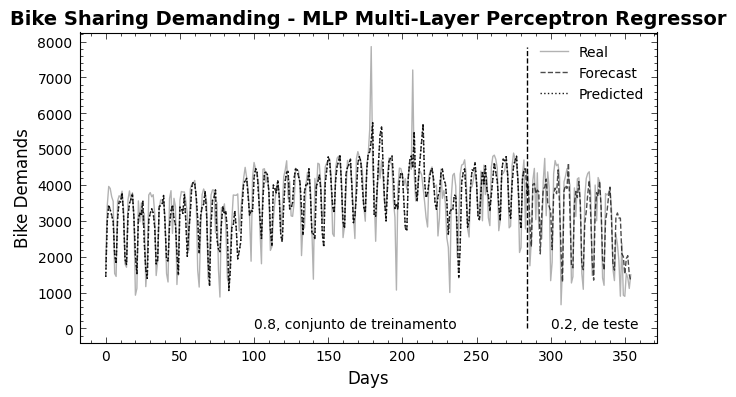

MSE: 	 479910.77
MAPE: 	 0.29
ME: 	 41.79
MAE: 	 563.62
MPE: 	 0.15
RMSE: 	 692.76
ACF1: 	 -0.06
CORR: 	 0.85


In [143]:
plot_forecast(y, y_pred, X_train, title='Bike Sharing Demanding - MLP Multi-Layer Perceptron Regressor')

cur_metrics = forecast_accuracy(y_pred[len(y_train):], y[len(y_train):].values.reshape(-1))
dict_metrics['MLPRegressor'] = cur_metrics

In [144]:
print('Mean Absolute Error')
print()

for key, item in dict_metrics.items():
  print(f"{key} MAE: {item['MAE']:.2f}")

Mean Absolute Error

ARIMA Model MAE: 539.22
DecisionTreeRegressor MAE: 687.96
GradientBoostingRegressor MAE: 665.43
MLPRegressor MAE: 563.62


Do mesmo modo que nos modelos anteriores o modelo MLP aproxima bastante bem a série de dados e poderíamos refinar o modelo para obter resultados ainda melhores. Em vez disso, vamos entender como podemos empregar esses mesmos modelos para Séries Multivariadas, isto é, adicionando uma variável exógena a exemplo do que você viu no capítulo anterior com o SARIMAX. Na verdade modelos Multivariados, são mais amplos e envolvem tanto múltiplas variáveis de entrada como de saída, mas aqui empregamos o termo unicamente denominar para Séries com mais de uma entrada.

## Modelo MultiVariado Simples, $(x^a_t, x^b_t,...) \rightarrow x^a_{t+1}$

Suponha que você tem uma série $x_t^a$ que deseja estimar os valores, por exemplo o número de Bikes alugadas. Sabendo, entretanto, que o aluguel dessas Bikes depende das condições do clima, podemos empregar não só os valores passados da série  $x_t^a$, mas também os valores da série de clima, como a temperatura  $x_t^b$ para aprimorar a previsão da série  $x_t^a$.

$$  f: (x_{t-n}^a,x_{t-n}^b), ..., (x_{t-1}^a,x_{t-1}^b)   \rightarrow x_t^a $$

Isso é bastante simples de fazer com modelos de Aprendizado de Máquina bastando, para isso, construir esse mapeamento de entradas e saídas adicionando a nova série de entradas.

Vamos adicionar ao nosso modelo de previsão anterior os dados de velocidade do vento e verificar o quanto o nosso modelo melhora na previsão de demanda por bicicletas.

In [145]:
df_wind = ml_timeseries_df(bikes[['wind_speed']], n_lags=7, prefix='wind_')
df_wind.head()

,wind_t-7,wind_t-6,wind_t-5,wind_t-4,wind_t-3,wind_t-2,wind_t-1,t
0,15.0,14.0,27.5,30.5,27.0,44.0,48.0,37.0
1,14.0,27.5,30.5,27.0,44.0,48.0,37.0,39.0
2,27.5,30.5,27.0,44.0,48.0,37.0,39.0,30.0
3,30.5,27.0,44.0,48.0,37.0,39.0,30.0,40.0
4,27.0,44.0,48.0,37.0,39.0,30.0,40.0,45.0


In [146]:
df = pd.concat([df_wind.drop(columns='t'), df],axis=1)
df.head()


,wind_t-7,wind_t-6,wind_t-5,wind_t-4,wind_t-3,wind_t-2,wind_t-1,t-7,t-6,t-5,t-4,t-3,t-2,t-1,t
0,15.0,14.0,27.5,30.5,27.0,44.0,48.0,1039.0,3161.0,3534.0,3618.0,2351.0,3505.0,1436.0,1813
1,14.0,27.5,30.5,27.0,44.0,48.0,37.0,3161.0,3534.0,3618.0,2351.0,3505.0,1436.0,1813.0,3418
2,27.5,30.5,27.0,44.0,48.0,37.0,39.0,3534.0,3618.0,2351.0,3505.0,1436.0,1813.0,3418.0,3960
3,30.5,27.0,44.0,48.0,37.0,39.0,30.0,3618.0,2351.0,3505.0,1436.0,1813.0,3418.0,3960.0,3904
4,27.0,44.0,48.0,37.0,39.0,30.0,40.0,2351.0,3505.0,1436.0,1813.0,3418.0,3960.0,3904.0,3673


In [147]:
X = df.drop(columns='t')
y = df[['t']]

X_train, y_train, X_test, y_test = split_train_test(X, y, test_perc=0.2)

In [148]:
from sklearn.neural_network import MLPRegressor

reg = MLPRegressor(hidden_layer_sizes=(8,16,8), random_state=1, max_iter=2000)
reg.fit(X_train,y_train.values.reshape(-1))

y_pred = reg.predict(X)

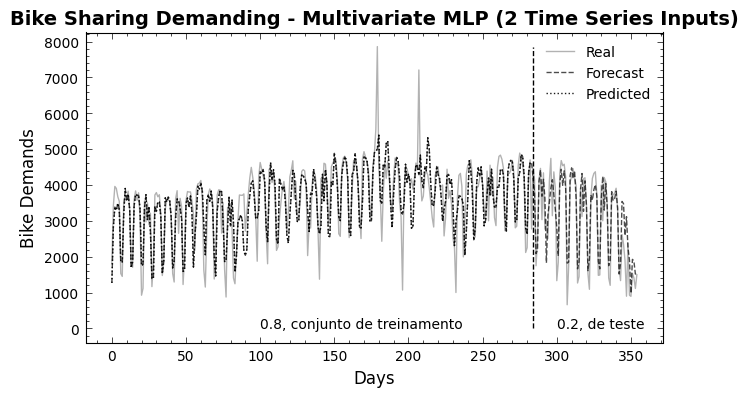

MSE: 	 386396.82
MAPE: 	 0.24
ME: 	 126.38
MAE: 	 459.65
MPE: 	 0.16
RMSE: 	 621.61
ACF1: 	 -0.11
CORR: 	 0.88


In [149]:
plot_forecast(y, y_pred, X_train, title='Bike Sharing Demanding - Multivariate MLP (2 Time Series Inputs)')

cur_metrics = forecast_accuracy(y_pred[len(y_train):], y[len(y_train):].values.reshape(-1))
dict_metrics['MLPRegressor with 2 input series'] = cur_metrics

In [150]:
print('Mean Absolute Error')
print()

for key, item in dict_metrics.items():
  print(f"{key} MAE: {item['MAE']:.2f}")

Mean Absolute Error

ARIMA Model MAE: 539.22
DecisionTreeRegressor MAE: 687.96
GradientBoostingRegressor MAE: 665.43
MLPRegressor MAE: 563.62
MLPRegressor with 2 input series MAE: 459.65


Nosso resultado agora é até mesmo melhor que o modelo unidimensional ARIMA e você pode ver que pudemos adaptar o modelo com o mínimo de esforço.

## Deep Learning

Séries Multivariadas e janelas de ciclo de tempo muito longas podem levar à necessidade de construirmos conjuntos de dados de muitas dimensões para podermos aplicar modelos de ML. Tratar grandes volumes de dados com alta dimensionalidade exige capacidade de processamento e otimizações de código que você encontra normalmente em Frameworks de redes profundas como o `PyTorch` (Meta) ou o `TensorFlow`(Google), ou mesmo no pacote de Séries Temporais da Meta, o `NeuralProphet`.

A construção detalhada desses modelos de Deep Learning e o uso desses Frameworks estão bem além do que caberia nesta introdução, mas dada a importância e o uso cada vez maior desses modelos, cabe ao menos criarmos um modelo simples, seguindo a nossa filosofia de criar uma porta de entrada à você para modelos mais sofisticados, mas sem entrar em detalhes da codificação que você poderá buscar mais adiante em outras referências.

Vamos empregar aqui o Framework `PyTorch`, sendo um dos mais empregados e bem-sucedidos Frameworks de redes profundas. Redes profundas normalmente são associadas a um grande número de camadas e  elementos. Na verdade, não é exatamente assim e podemos encontrar redes Deep Learning que tenham mesmo um número pequeno de elementos e camadas (para os padrões de centenas e milhares que em geral encontramos). Uma das possibilidades que torna o uso de redes neurais profundas particularmente interessantes para a predição de Séries Temporais é que podemos implementar arquiteturas recorrentes em que a saída da rede realimenta a rede, podendo-se definir ainda a profundidade dessa realimentação. Você deve notar a semelhança disso com o próprio conceito de Séries Temporais.

No modelo a seguir empregaremos uma arquitetura **LSTM**, ou **Long Short-Term Memory**, que é uma arquitetura de rede neural recorrente artificial capaz de processar sequências inteiras de dados. Vamos fazer aqui uma predição empregando unicamente a Série de Dados de demanda de bicicletas. O código apresenta uma série de desafios técnicos para o iniciante e sugiro você seguir, em um primeiro momento, apenas os comentários do que cada parte está construindo.



### Imports

In [151]:
import torch
import torch.nn as nn
from torch.autograd import Variable

### Preparação dos Dados

Os dados serão organizados do mesmo modo que empregamos antes, embora existam, no caso das redes LSTM outras formas mais eficientes de empregarmos.

In [152]:
df = ml_timeseries_df(bikes[['cnt']], n_lags=7)
df.head(7)

,t-7,t-6,t-5,t-4,t-3,t-2,t-1,t
0,1039.0,3161.0,3534.0,3618.0,2351.0,3505.0,1436.0,1813
1,3161.0,3534.0,3618.0,2351.0,3505.0,1436.0,1813.0,3418
2,3534.0,3618.0,2351.0,3505.0,1436.0,1813.0,3418.0,3960
3,3618.0,2351.0,3505.0,1436.0,1813.0,3418.0,3960.0,3904
4,2351.0,3505.0,1436.0,1813.0,3418.0,3960.0,3904.0,3673
5,3505.0,1436.0,1813.0,3418.0,3960.0,3904.0,3673.0,3546
6,1436.0,1813.0,3418.0,3960.0,3904.0,3673.0,3546.0,1531


Modelos de Deep Learning empregam os dados no formato de **Tensores** que são arrays multidimensionais bastante semelhantes aos empregados no `NumPy` mas que possuem algoritmos mais eficientes para o processamento além de acesso a recursos de GPU. Nesses modelos dos dados de entrada e saída são em geral normalizados.

In [153]:
min = df.min().min()
max = df.max().max()

In [154]:
for c in df:
  df[c] = ( df[c] - min ) / ( max - min )

Dados normalizados:

In [155]:
df.head(7)

,t-7,t-6,t-5,t-4,t-3,t-2,t-1,t
0,0.052639,0.347361,0.399167,0.410833,0.234861,0.395139,0.107778,0.160139
1,0.347361,0.399167,0.410833,0.234861,0.395139,0.107778,0.160139,0.383056
2,0.399167,0.410833,0.234861,0.395139,0.107778,0.160139,0.383056,0.458333
3,0.410833,0.234861,0.395139,0.107778,0.160139,0.383056,0.458333,0.450556
4,0.234861,0.395139,0.107778,0.160139,0.383056,0.458333,0.450556,0.418472
5,0.395139,0.107778,0.160139,0.383056,0.458333,0.450556,0.418472,0.400833
6,0.107778,0.160139,0.383056,0.458333,0.450556,0.418472,0.400833,0.120972


Armazenados como Tensores e separados nos conjuntos de Treinamento e Teste como antes. Note a dimensão dos Tensores.

In [156]:
X = df.drop(columns='t')
y = df[['t']]

X = torch.tensor(np.array(X)).unsqueeze(-1)
y = torch.tensor(np.array(y))

X = X.type(torch.float)
y = y.type(torch.float)

X_train, y_train, X_test, y_test = split_train_test(X, y, test_perc=0.2)

In [157]:
X.shape

torch.Size([355, 7, 1])

In [158]:
y.shape

torch.Size([355, 1])

### Modelo da Rede e Treinamento

As duas funções a seguir são modelos bastante típicos de definição de uma rede e do seu treinamento e você, se tiver interesse, pode encontrar inúmeras referências e tutoriais dessas funções no site do projeto https://pytorch.org/.

#### Classe de Definição da Rede LSTM

In [159]:
class LSTM(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, (h_out, cn) = self.lstm(x)

        h_out = h_out[-1]                         # saída da última camada para a camada fc
        h_out = h_out.view(-1,self.hidden_size)
        out_final = self.fc(h_out)

        return out_final

#### Classe de Treinamento da Rede

De modo análogo a um modelo neural em camadas o aprendizado, ou o ajuste dos pesos da rede, se dá de forma iterativa e emprega um otimizador que busca a cada etapa do treinamento encontrar valores para os pesos que minimizem o erro de saída do modelo.

In [160]:
def train(model, optmizer, loss_f, num_epochs, data_train_x, data_train_y):

  for epoch in range(num_epochs):

    outputs = model(data_train_x)
    loss = loss_f(outputs, data_train_y)

    optimizer.zero_grad()
    loss.backward()

    optimizer.step()
    if epoch % 500 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

In [165]:
num_epochs = 2000
learning_rate = 0.01

input_size = 1 # input size!!! uma única série de dados
hidden_size = 8

for num_layers in range(2,3):

  model = LSTM(input_size, hidden_size, num_layers)

  loss_function = torch.nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  train(model, optimizer, loss_function, num_epochs, X_train, y_train)

  model.eval()


Epoch: 0, loss: 0.13333
Epoch: 500, loss: 0.00673
Epoch: 1000, loss: 0.00565
Epoch: 1500, loss: 0.00325


In [166]:
prediction = model(X)
data_predict = prediction.data.numpy()


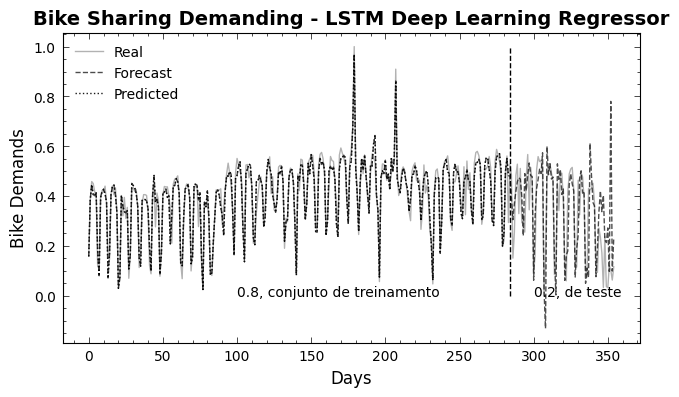

In [167]:
plot_forecast(df[['t']] , data_predict, X_train, title='Bike Sharing Demanding - LSTM Deep Learning Regressor')

Para obtermos as métricas nas mesmas medidas dos modelos anteriores vamos reescalar novamente os dados voltando aos valores originais antes da normalização.

In [164]:
y_forecast = data_predict[train_size::].reshape(-1) * (max - min) + min
y_real = np.array( y[train_size::] ).reshape(-1) * (max - min) + min

cur_metrics = forecast_accuracy(y_forecast, y_real)

dict_metrics['LSTM Deep Learning Regressor'] = cur_metrics

MSE: 	 1748582.62
MAPE: 	 0.55
ME: 	 487.16
MAE: 	 887.19
MPE: 	 0.46
RMSE: 	 1322.34
ACF1: 	 0.29
CORR: 	 0.43


Embora neste exemplo os resultados estejam abaixo dos modelos anteriores, é claro a capacidade desse modelo fazer previsões e diversos ajustes poderiam ser feitos para atingirmos melhores resultados. Por exemplo, poderíamos adicionar uma segunda Série de Dados (a velocidade do vento) como no exemplo anterior. A  otimização de redes profundas, entretanto, é um tema avançado e concluímos aqui apenas com o  esquema geral de sua aplicação.

# Sumário

Aqui você conheceu e aprendeu como aplicar uma série de modelos de Aprendizado de Máquina, incluindo modelos sofisticados de Redes Neurais Profundas, na predição de Séries Temporais. Esses modelos vem sendo cada vez mais aplicados em diversos campos, e ferramentas poderosas vem empregando essas técnicas para Séries com grandes volumes de dados, alta dimensionalidade e complexidade.

Embora de modo prático esses modelos de ML sejam bastante poderosos e fáceis de serem aplicados (veja que independente de seu conhecimento de `Python` são poucas linhas de código para implementar modelos sofisticados), esses modelos requerem cuidado e, muitas vezes, não fornecem qualquer valor explicativo sobre as Séries, como vimos antes nos modelos estatísticos mais tradicionais (AR, MA, ARMA, ARIMA, SARIMAX etc.). Esses continuam a ser modelos essenciais de análise de Séries Temporais e recomendamos que você empregue modelos de ML em conjunto com modelos mais tradicionais. Um princípio importante da modelagem, o princípio da **Navalha de Ockham** ou **Princípio da Parcimônia**, prega que entre dois modelos que apresentam a mesma eficiência você deve optar pelo modelo mais simples, que reduz o número de hipóteses envolvidas, e uma grande parte dos problemas de Séries Temporais ainda parecem poderem ser melhor resolvidas com modelos tradicionais e que fornecem ainda informações importantes da estrutura dos dados.

Apesar disso, os modelos de Aprendizado de Máquina e Redes Profundas são cada vez mais empregados e podem encontrar aplicações bastante práticas e sugerimos você se familiarizar com eles.






# Para Saber Mais

* O site http://playground.tensorflow.org/ permite você experimentar um modelo neural sem a necessidade de codificar. Esse *playground* está configurado inicialmente para tarefas de classificação, mas você pode setar o tipo de problema para *regressão* que é o que estudamos aqui. Lá você poderá configurar o número camadas da rede, o número de elementos, a função de ativação e acompanhar o treinamento da rede a curva de aprendizado do modelo (a evolução da função de erro).  

* VANDERPLAS, Jake. **Python data science handbook: Essential tools for working with data.** O'Reilly Media, Inc., 2016. https://jakevdp.github.io/PythonDataScienceHandbook/.Esta é uma boa referência para você conhecer os principais algoritmos de aprendizado de máquina aplicando a problemas com o `scikit-learn`.

* Acesse os cursos do **Kaggle**, em https://www.kaggle.com/learn, os cursos **Intro to Machine Learning**, **Intro to Deep Learning** constituem uma boa e prática introdução ao Aprendizado de Máquina e Aprendizado Profundo, e o curso **Time Series** traz enfoque também no Aprendizado de Máquina.


